In [1]:
#! pip install mlflow

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

2023-03-01 19:45:58.951077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-01 19:46:03.982071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import pandas as pd
import numpy as np
import datetime
from pandas_summary import DataFrameSummary

In [4]:
from mlflow import log_metric
import mlflow.tensorflow

In [5]:
from tensorflow.keras.utils import to_categorical

In [6]:
resultPath=''
df = pd.read_feather('train_normalized_data.fth')
df_test = pd.read_feather('test_normalized_data.fth')

In [7]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen', 'Promo2Weeks', 
            'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear', 'State', 
            'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_bool_fw', 'StateHoliday_bool_bw', 'SchoolHoliday_fw', 'SchoolHoliday_bw']

#cat_vars = ['Store', 'DayOfWeek']

In [8]:
contin_vars = ['CompetitionDistance', 
   'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC', 'Precipitationmm',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday_bool', 'BeforeStateHoliday_bool', 'Promo', 'SchoolHoliday', 'StateHoliday_bool']

contin_vars = ['CompetitionDistance',
               'Max_TemperatureC', 'Precipitationmm',
               'Max_Humidity', 'CloudCover', 'trend',
               'AfterStateHoliday_bool', 'Promo']


#contin_vars = ['BeforeStateHoliday_bool', 'Max_TemperatureC']

In [9]:
uniques = DataFrameSummary(df[cat_vars]).summary().loc[['uniques']]

In [10]:
uniques.T

,uniques
Store,1115
DayOfWeek,7
Year,3
Month,12
Day,31
StateHoliday,4
CompetitionMonthsOpen,25
Promo2Weeks,26
StoreType,4
Assortment,3


# Asignación de dimensión de embeddings

In [11]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 2, 'Year': 2, 'Month': 2,
'Day': 10, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
'Promo2Weeks': 1, 'StoreType': 2, 'Assortment': 3, 'PromoInterval': 3,
'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
'Week': 25, 'Events': 4, 'Promo_fw': 1,
'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
'SchoolHoliday_bw': 1}

In [12]:
cat_var_dict = {'Store': 50, 'DayOfWeek': 3, 'Year': 2, 'Month': 4,
                'Day': 8, 'StateHoliday': 2, 'CompetitionMonthsOpen': 2,
                'Promo2Weeks': 2, 'StoreType': 3, 'Assortment': 3, 'PromoInterval': 3,
                'CompetitionOpenSinceYear': 4, 'Promo2SinceYear': 4, 'State': 6,
                'Week': 25, 'Events': 4, 'Promo_fw': 1,
                'Promo_bw': 1, 'StateHoliday_bool_fw': 1,
                'StateHoliday_bool_bw': 1, 'SchoolHoliday_fw': 1,
                'SchoolHoliday_bw': 1}

In [13]:
for v in cat_vars:
    uniques_ = df[v].unique()
    uniques_.sort()
    print(v, cat_var_dict[v], len(uniques_), uniques_)
    print()

Store 50 1115 [   0    1    2 ... 1112 1113 1114]

DayOfWeek 3 7 [0 1 2 3 4 5 6]

Year 2 3 [0 1 2]

Month 4 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Day 8 31 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]

StateHoliday 2 4 [0 1 2 3]

CompetitionMonthsOpen 2 25 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]

Promo2Weeks 2 26 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]

StoreType 3 4 [0 1 2 3]

Assortment 3 3 [0 1 2]

PromoInterval 3 4 [0 1 2 3]

CompetitionOpenSinceYear 4 21 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]

Promo2SinceYear 4 8 [0 1 2 3 4 5 6 7]

State 6 12 [ 0  1  2  3  4  5  6  7  8  9 10 11]

Week 25 52 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51]

Events 4 22 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 

# Definición de modelo

In [14]:
add_customers = True
log_output = True
output_activation = 'linear'

In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, BatchNormalization, Activation, LeakyReLU, Dropout
from tensorflow.keras.regularizers import l2

In [16]:
def get_cat_vars_model(cat_vars, uniques, cat_var_dict):
    cat_vars_embed_outs = []
    cat_var_inputs = []
    for cat_var in cat_vars:
        cat_var_in = Input(shape=(1,), name=f"{cat_var}_input")
        cat_var_inputs.append(cat_var_in)
        embed_out = Embedding(uniques[cat_var][0], cat_var_dict[cat_var], name=f'{cat_var}_Embed')(cat_var_in)
        flatten_out = Flatten(name=f"{cat_var}_flat")(embed_out)
        cat_vars_embed_outs.append(flatten_out)
    return cat_var_inputs, cat_vars_embed_outs

def get_cont_vars_input(contin_vars, dense_layer=False):
    cont_vars_inputs = []
    cont_vars_outputs = []
    for cont_var in contin_vars:
        cont_var_in = Input(shape=(1,), name=f"{cont_var}_input")
        cont_vars_inputs.append(cont_var_in)
        if dense_layer:
            cont_var_out = Dense(1, name=f"{cont_var}_input", activation = 'linear')(cont_var_in)
            cont_vars_outputs.append(cont_var_out)
        else:
            cont_vars_outputs.append(cont_var_in)
    return cont_vars_inputs, cont_vars_outputs

In [17]:
cat_var_inputs, cat_vars_embed_outs = get_cat_vars_model(cat_vars, uniques, cat_var_dict)
cont_vars_inputs,  cont_vars_outs= get_cont_vars_input(contin_vars)

In [18]:
mlflow.autolog()

2023/03/01 19:46:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


In [19]:
# Descomentar para ver resultados
# cat_vars_embed_outs
# cat_var_inputs
# cont_vars_inputs
# cont_vars_outs
#cat_vars
#uniques
#cat_var_dict

In [20]:
first_hidden_units = 1000
second_hidden_units = 500
l2_lambda = 0.0001
merged = Concatenate(name='All_Concatenate')(cat_vars_embed_outs + cont_vars_inputs)
x = Dense(first_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(merged)
x = BatchNormalization()(x)
#x = Activation('relu')(x)
x = LeakyReLU()(x)
x = Dropout(0.02)(x)
x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = LeakyReLU()(x)

x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)

x = Dense(second_hidden_units, kernel_initializer="uniform", kernel_regularizer=l2(l2_lambda))(x)
# x = BatchNormalization()(x)
x = Activation('relu')(x)

output_1 = Dense(1, name='Sales', activation=output_activation)(x)
output_2 = Dense(1, name='Customers', activation=output_activation)(x)

In [21]:
if add_customers:
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1, output_2])
else: 
    model = Model(cat_var_inputs + cont_vars_inputs, [output_1])

In [22]:
# Descomentar para ver
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                              

In [23]:
model.save_weights('initial_weights.hdf5')

In [24]:
df_train = df[df.Date < datetime.datetime(2015, 7, 1)]  
df_val = df[df.Date >= datetime.datetime(2015, 7, 1)]
print(f'Cantidad en val: {len(df_val)}, porcentaje: {len(df_train)/(len(df_train) + len(df_val))}')

Cantidad en val: 30188, porcentaje: 0.9642465458145908


In [25]:
from matplotlib import pyplot as plt
# plt.figure(figsize=(20,5))
# plt.plot((df_train[df_train['Store']==1]['Sales'].values - df_train[df_train['Store']==1]['Sales'].mean())/df_train[df_train['Store']==1]['Sales'].std())
# plt.show()
# plt.figure(figsize=(20,5))
# plt.plot(np.log(df_train[df_train['Store']==1]['Sales'].values)/np.max(np.log(df_train[df_train['Store']==1]['Sales'].values)))
# plt.show()

In [26]:
stores_mean = {}
for store, g_df in df_train.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [27]:
df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)

df_train.loc[:, 'Sales_store'] = df_train['Sales'] - df_train['mean_by_store']
df_val.loc[:, 'Sales_store'] = df_val['Sales'] - df_val['mean_by_store']

/var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/ipykernel_10655/3553976367.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'mean_by_store'] = df_train['Store'].apply(stores_mean.get)
/var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/ipykernel_10655/3553976367.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'mean_by_store'] = df_val['Store'].apply(stores_mean.get)
/var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/ipykernel_10655/3553976367.py:4: SettingWithCopyWarning: 
A

In [28]:
from tensorflow.keras import backend as K

In [29]:
def rmspe(y_true, y_pred):
    return K.sqrt(K.mean(K.square((y_true - y_pred)/y_true)))

In [30]:
def get_metric(df, sales_):
    return np.sqrt((((df['Sales'] - sales_)/df['Sales'])**2).mean())

In [31]:
get_metric(df_val, df_val['mean_by_store'])

0.30717460853388645

In [32]:
all_vars = cat_vars + contin_vars
X_train = np.hsplit(df_train[all_vars].values, len(all_vars))
X_val = np.hsplit(df_val[all_vars].values, len(all_vars))
X_test = np.hsplit(df_test[all_vars].values, len(all_vars))

In [33]:
if add_customers:
    y_out_columns = ['Sales', 'Customers']
else:
    y_out_columns = ['Sales_store']
    
if log_output:
    # Escala logaritmica
    max_log_y = np.max(np.log(df[y_out_columns])).values
    y_train = np.log(df_train[y_out_columns].values)/max_log_y
    y_val = np.log(df_val[y_out_columns].values)/max_log_y
else:
    # Normalización
    y_mean = df_train[y_out_columns].mean().values
    y_std = df_train[y_out_columns].std().values
#     y_train = (df_train[y_out_columns].values - y_mean)/y_std
#     y_val = (df_val[y_out_columns].values - y_mean)/y_std
    y_max = df_train[y_out_columns].max().values
    y_train = df_train[y_out_columns].values/y_max
    y_val = df_val[y_out_columns].values/y_max
y_train = np.hsplit(y_train, y_train.shape[1])
y_val = np.hsplit(y_val, y_val.shape[1])

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [34]:
lr = 0.005
model.compile(optimizer=Adam(lr=lr), metrics=['mse', rmspe], loss='mse')

In [35]:
if add_customers:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_Sales_mse', verbose=1, save_best_only=True)
else:
    checkpoint = ModelCheckpoint('bestmodel.hdf5', monitor='val_loss', verbose=1, save_best_only=True)

In [36]:
# callbacks
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, restore_best_weights=True)
reduceLR = ReduceLROnPlateau(monitor ='val_loss', factor=0.2, patience=15, verbose=1, mode='auto', min_delta=0.01, cooldown=0, min_lr=1e-8)

In [37]:
%%time
epochs = 200
batch_size = 256
history = model.fit(X_train, y_train, validation_data=(X_val, y_val),  epochs=epochs, batch_size=batch_size, callbacks=[checkpoint, earlyStopping, reduceLR], verbose=2)

2023/03/01 19:46:10 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5b70fa1b1cba496890a6158f8dc22c0c', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow


Epoch 1/200

Epoch 1: val_Sales_mse improved from inf to 0.00021, saving model to bestmodel.hdf5
3181/3181 - 66s - loss: 0.0243 - Sales_loss: 0.0022 - Customers_loss: 0.0016 - Sales_mse: 0.0022 - Sales_rmspe: 0.0377 - Customers_mse: 0.0016 - Customers_rmspe: 0.0416 - val_loss: 0.0019 - val_Sales_loss: 2.1416e-04 - val_Customers_loss: 2.8903e-04 - val_Sales_mse: 2.1416e-04 - val_Sales_rmspe: 0.0176 - val_Customers_mse: 2.8903e-04 - val_Customers_rmspe: 0.0227 - lr: 0.0010 - 66s/epoch - 21ms/step
Epoch 2/200

Epoch 2: val_Sales_mse improved from 0.00021 to 0.00021, saving model to bestmodel.hdf5
3181/3181 - 62s - loss: 9.0278e-04 - Sales_loss: 2.1534e-04 - Customers_loss: 2.5124e-04 - Sales_mse: 2.1534e-04 - Sales_rmspe: 0.0181 - Customers_mse: 2.5124e-04 - Customers_rmspe: 0.0220 - val_loss: 5.8794e-04 - val_Sales_loss: 2.1142e-04 - val_Customers_loss: 2.1498e-04 - val_Sales_mse: 2.1142e-04 - val_Sales_rmspe: 0.0173 - val_Customers_mse: 2.1498e-04 - val_Customers_rmspe: 0.0199 - lr: 0.0

2023/03/01 21:25:20 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: Cannot log input example or model signature for input with type <class 'list'>. TensorFlow Keras autologging can only log input examples and model signatures for the following input types: numpy.ndarray, dict[string -> numpy.ndarray], tensorflow.keras.utils.Sequence, and tensorflow.data.Dataset (TensorFlow >= 2.1.0 required)
2023/03/01 21:25:20 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/tmph3cqxti1/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/tmph3cqxti1/model/data/model/assets
2023/03/01 21:25:33 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/cc/hfx_w22x28j8f0l38h8ww1zc0000gn/T/tmph3cqxti1/model, flavor: tensorflow), fall back to return ['tensorflow==2.11.0']. Set logging level to DEBUG to see the full traceback.
2023/03/01 21:25:33 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


CPU times: user 5h 53min 55s, sys: 1h 53min 12s, total: 7h 47min 8s
Wall time: 1h 39min 23s


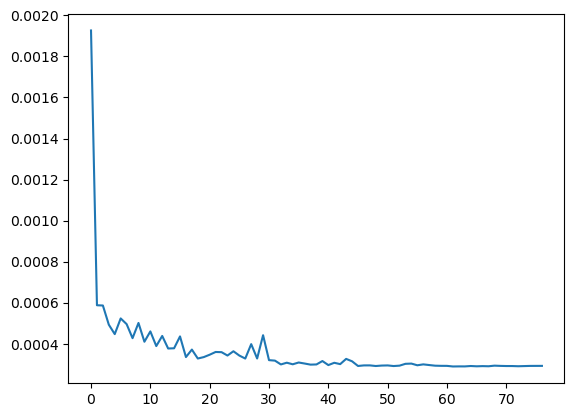

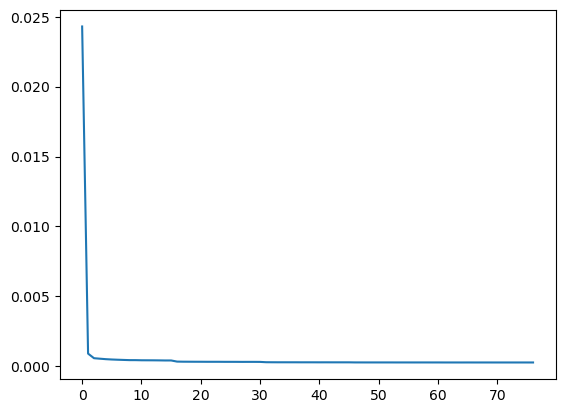

In [38]:
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_Customers_mse'])
# plt.plot(history.history['val_Sales_mse'])
plt.show()
plt.plot(history.history['loss'])
# plt.plot(history.history['Customers_mse'])
# plt.plot(history.history['Sales_mse'])

# Métrica

$$
\textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{\hat{y}_i - y_i}{y_i}\right)^2}
$$

In [39]:
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 2.8981e-04 - Sales_loss: 1.1761e-04 - Customers_loss: 1.2345e-04 - Sales_mse: 1.1761e-04 - Sales_rmspe: 0.0128 - Customers_mse: 1.2345e-04 - Customers_rmspe: 0.0147


[0.00028981451760046184,
 0.00011760566121665761,
 0.00012345367576926947,
 0.00011760566121665761,
 0.012838313356041908,
 0.00012345367576926947,
 0.01471603661775589]

In [40]:
#model.load_weights('bestmodel.hdf5')
model.evaluate(X_val, y_val)

944/944 [==============================] - 3s 3ms/step - loss: 2.8981e-04 - Sales_loss: 1.1761e-04 - Customers_loss: 1.2345e-04 - Sales_mse: 1.1761e-04 - Sales_rmspe: 0.0128 - Customers_mse: 1.2345e-04 - Customers_rmspe: 0.0147


[0.00028981451760046184,
 0.00011760566121665761,
 0.00012345367576926947,
 0.00011760566121665761,
 0.012838313356041908,
 0.00012345367576926947,
 0.01471603661775589]

A superar

loss: 0.0017 - Sales_loss: 0.0013 - Customers_loss: 3.0471e-04 - Sales_mse: 0.0013 - Sales_rmspe: 0.2060 - Customers_mse: 3.0471e-04 - Customers_rmspe: 0.1715

[0.0016888834070414305,
 0.001275751506909728,
 0.00030471361242234707,
 0.001275751506909728,
 0.20596320927143097,
 0.00030471361242234707,
 0.17151840031147003]


Epoch 20: val_Sales_mse did not improve from 0.00128
3181/3181 - 28s - loss: 0.0022 - Sales_loss: 0.0017 - Customers_loss: 3.5647e-04 - Sales_mse: 0.0017 - Sales_rmspe: 0.2827 - Customers_mse: 3.5647e-04 - Customers_rmspe: 0.2046 - val_loss: 0.0017 - val_Sales_loss: 0.0013 - val_Customers_loss: 3.1156e-04 - val_Sales_mse: 0.0013 - val_Sales_rmspe: 0.2137 - val_Customers_mse: 3.1156e-04 - val_Customers_rmspe: 0.1805 - 28s/epoch - 9ms/step

In [41]:
# model.load_weights('bestmodel.hdf5')
# model.evaluate(X_val, y_val)
# 30188/30188 [==============================] - 5s 172us/step
# [0.12197033089921382,
#  0.07211007360268763,
#  0.037183713050426136,
#  0.07211007360268763,
#  0.037183713050426136]

# [0.12932546436786652,
#  0.07751645147800446,
#  0.039259567856788635,
#  0.07751645147800446,
#  0.039259567856788635]

In [42]:
if log_output:
    if add_customers:
        y_pred = np.exp(model.predict(X_val, verbose=1)[0][:, 0]*max_log_y[0])
        y_pred_test = np.exp(model.predict(X_test, verbose=1)[0][:, 0]*max_log_y[0])
    else:
        y_pred = np.exp(model.predict(X_val, verbose=1)*max_log_y)[:,0]
        y_pred_test = np.exp(model.predict(X_test, verbose=1)*max_log_y)[:,0]
else:
    if add_customers:
        y_pred = (model.predict(X_val, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
        y_pred_test = (model.predict(X_test, verbose=1)[0]*y_std[0] + y_mean[0])[:,0]
    else:
#         y_pred = model.predict(X_val, verbose=1)[:,0]*y_std + y_mean
#         y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_std + y_mean
        y_pred = model.predict(X_val, verbose=1)[:,0]*y_max
        y_pred_test = model.predict(X_test, verbose=1)[:,0]*y_max
y_pred_test[df_test['Open'] == 0] = 0

1284/1284 [==============================] - 4s 3ms/step


In [43]:
metric_sales = np.sqrt((((df_val['Sales'].values - y_pred)/df_val['Sales'].values)**2).sum()/len(y_pred))
log_metric("metric_sales", metric_sales)
metric_sales

0.12201811399033238

In [44]:
y_pred_test[:10]

array([4180.716 , 6715.649 , 9006.316 , 6173.8853, 6992.953 , 5613.672 ,
       7739.0913, 7641.1343, 4403.6714, 5605.7812], dtype=float32)

# Baseline

In [45]:
import pandas as pd
sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')

In [46]:
stores_mean = {}
for store, g_df in df.groupby('Store'):
    stores_mean[store] = g_df[g_df['Sales'] > 0]['Sales'].mean()

In [47]:
df_test['Sales'] = df_test['Store'].apply(stores_mean.get)
df_test.loc[df_test['Open'] == 0, 'Sales'] = 0

In [48]:
df_test[['Store', 'Sales']].head(10)

,Store,Sales
0,0,4759.096031
1,2,6942.568678
2,6,8817.050891
3,7,5539.358418
4,8,6562.337612
5,9,5568.420918
6,10,8030.977041
7,11,7589.598214
8,12,5034.747182
9,13,5508.567394


In [49]:
df_test[df_test['Open'] == 0][['Store', 'Sales']].head()

,Store,Sales


In [50]:
sample_csv['Sales'] = df_test['Sales']

In [51]:
sample_csv.to_csv(f'submision_baseline.csv', index=False)

In [52]:
sample_csv.head()

,Id,Sales
0,1,4759.096031
1,2,6942.568678
2,3,8817.050891
3,4,5539.358418
4,5,6562.337612


# Sumbit a la competición

In [53]:

sample_csv = pd.read_csv('dataset/rossmann/sample_submission.csv')
sample_csv['Sales'] = y_pred_test
sample_csv.head()

sample_csv.to_csv(f'c06-submision_{add_customers}-{log_output}-{output_activation}-{l2_lambda}-{first_hidden_units}-{epochs}-{batch_size}-{lr}.csv', index=False)


# Analisis de embedings

In [54]:
def plot_embed(layer_name, cat_names):
    Y = model.get_layer(layer_name).get_weights()[0]
    print(Y.shape)
    plt.figure(figsize=(8,8))
    plt.scatter(-Y[:, 0], -Y[:, 1])
    for i, txt in enumerate(cat_names):
        plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

(7, 3)


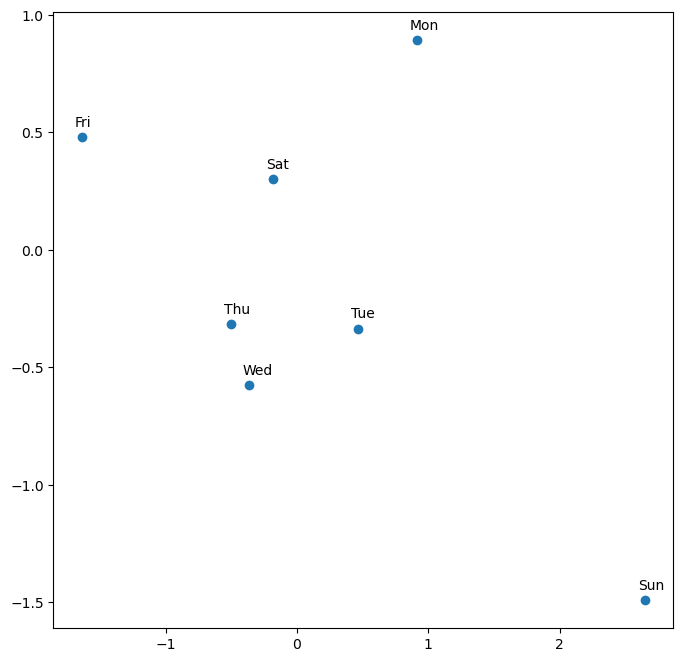

In [55]:
model.load_weights('bestmodel.hdf5')
plot_embed('DayOfWeek_Embed', ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun'])

(22, 4)


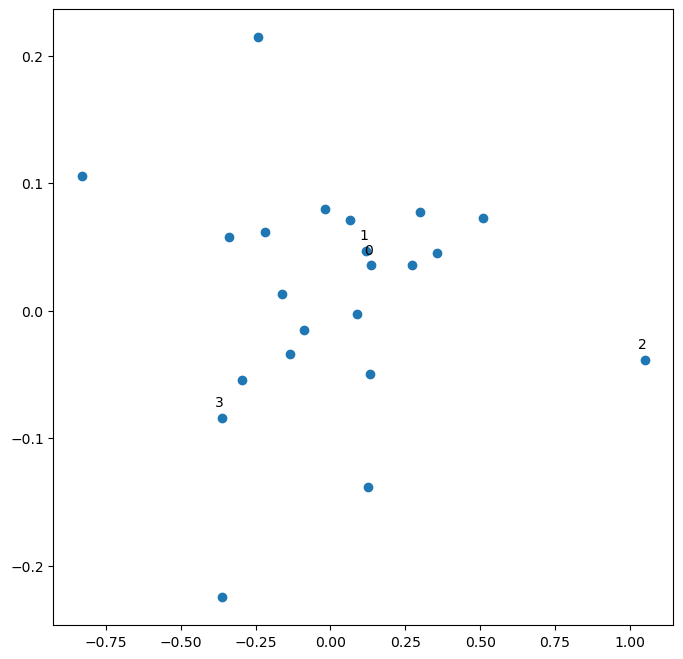

In [56]:
#plot_embed('Month_Embed', list(range(12)))
plot_embed('Events_Embed', list(range(4)))

In [57]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

2023/03/01 21:25:51 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.


In [58]:
day_of_week_embedding = model.get_layer('DayOfWeek_Embed').get_weights()[0]
day_of_week_embedding.shape

(7, 3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
2023/03/01 21:25:51 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2023/03/01 21:25:51 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2023/03/01 21:25:51 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!


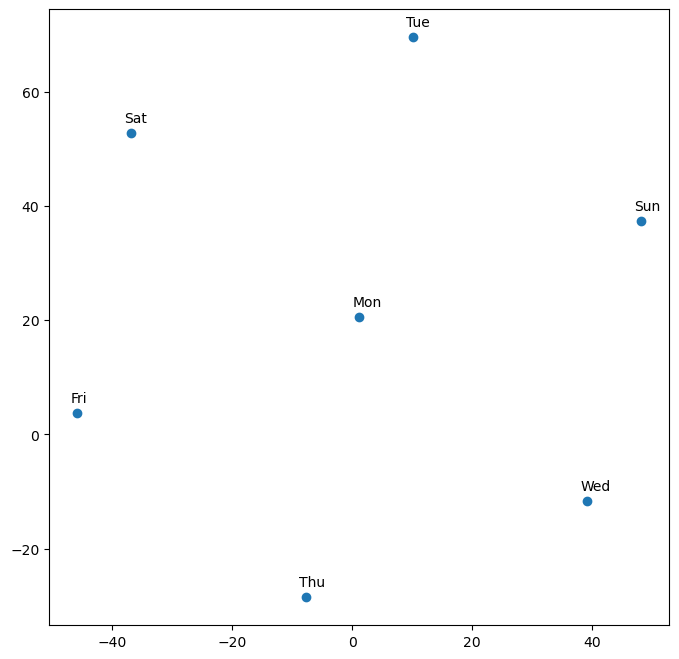

In [59]:
tsne = TSNE(n_components=2, random_state=1, learning_rate=10, n_iter=10000)
Y = tsne.fit_transform(day_of_week_embedding)
names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat','Sun']
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(names):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-5, 8), textcoords = 'offset points')

## Store embeddings

In [60]:
submodel = Model(cat_var_inputs + cont_vars_inputs, merged)

In [61]:
submodel.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Store_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 DayOfWeek_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 Year_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Month_input (InputLayer)       [(None, 1)]          0           []                               
                                                                                            

In [62]:
submodel.save('embeddings_model.hdf5')

In [63]:
from datetime import datetime

# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d/%m/%Y %H:%M:%S")
print("date and time =", dt_string)

date and time = 01/03/2023 21:25:55


In [64]:
#! mlflow ui